In [1]:
import pandas as pd
import numpy as np
from os import getcwd, path

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer


from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

import matplotlib.pyplot as plt

from collections import defaultdict

from re import compile

plt.style.use('ggplot')

## Parameters

In [2]:
sent_tokenizer = False # S
use_pretrained_embeddings = True

use_nltk_cleaning = False
text_cleaning = True

use_tfidf_tokenizer = True
use_keras_tokenizer = False

make_all_other_classes_1 = True
remove_class_0 = False

## Functions

In [3]:
def plot_history(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
def create_embedding_matrix(filepath, word_index, embedding_dim):
    
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix


def cal_label_accuracy(conf_matrix, verbose = 0):
    
    label_acc = {}
    
    for index, x in enumerate(conf_matrix): 
        
        label_acc[index] = np.round( conf_matrix[index][index]/ sum(conf_matrix[index]) *100 , 2)
        
        if verbose > 0:
        
            print("Accuracy for label", index, ": ", label_acc[index] , " %" )
    
    return label_acc

    
def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text


## Data Ingest

## Use 5 Category Data

In [4]:
data_dir = 'D:/Data_Science/ClassificationProblems/Sentiment_Analysis/data/SA_4_Categories.csv'
corpus = pd.read_csv(data_dir ,encoding='latin-1', sep = ';')

## Use 2 Category Data

In [32]:
# current_path = getcwd()

# filepath_dict = {'yelp':   'data/yelp_labelled.txt',
#                  'amazon': 'data/amazon_cells_labelled.txt',
#                  'imdb':   'data/imdb_labelled.txt'}

# df_list = []

# for source, filepath in filepath_dict.items():
    
#     df = pd.read_csv(path.join(current_path, filepath), names=['sentence', 'label'], sep='\t')
#     df['source'] = source  # Add another column filled with the source name
#     df_list.append(df)

# df = pd.concat(df_list)
# df.rename(columns = {'sentence':'text'}, inplace = True)
# corpus = df

In [5]:
corpus.head()

,text,label
0,The stable way of business life many corporate...,0
1,"As dozens of companies have already learned, s...",0
2,What capabilities will a profitable internatio...,0
3,Almost every kind of manufacturer will have to...,0
4,Some companies have already responded to the g...,0


In [6]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609 entries, 0 to 1608
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1609 non-null   object
 1   label   1609 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.3+ KB


## 0. Text Cleaning

In [7]:
if text_cleaning:

    corpus = corpus.reset_index(drop=True)

    REPLACE_BY_SPACE_RE = compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
  
    corpus['text'] = corpus['text'].apply(clean_text)
    corpus['text'] = corpus['text'].str.replace('\d+', '')

In [9]:
# Create Filter on the data to avoid the imbalance classes problem
if make_all_other_classes_1:

    corpus['label_orignal'] = corpus.loc[:,'label']
    corpus['label'] = np.where( corpus['label'] > 0 , 1, corpus['label'])

elif remove_class_0:

    corpus['label_orignal'] = corpus.loc[:,'label']
    corpus = corpus[~corpus['label'].isin([0])]
    corpus['label'] = corpus['label'].map({1:0,2:1,3:2,4:3})

In [10]:
corpus.head()

,text,label,label_orignal
0,stable way business life many corporate purcha...,0,0
1,dozens companies already learned supply demand...,0,0
2,capabilities profitable international business...,0,0
3,almost every kind manufacturer answer questions,0,0
4,companies already responded growing pressures,0,0


In [11]:
corpus['label'].unique()

array([0, 1], dtype=int64)

## 1. NLTK - Data preprocessing

- I. Remove Blank rows in Data, if any
- II. Change all the text to lower case
- III. Word Tokenization
- IV. Remove Stop words
- V. Remove Non-alpha text
- VI. Word Lemmatization

In [12]:
if use_nltk_cleaning:

    # Step III : Tokenization : In this each entry in the corpus will be broken into set of words
    if sent_tokenizer: 
        corpus['text'] = [sent_tokenize(x) for x in corpus['text']] 
    else:
        #Corpus['text'] = Corpus['text'].apply(lambda x: str(word_tokenize(x)) )
        corpus['text'] = [word_tokenize(x) for x in corpus['text']]

    # Step IV, V, VI : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
    # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
    # Word Classification for Lemmatizer https://www.nltk.org/_modules/nltk/corpus/reader/wordnet.html
    # https://www.geeksforgeeks.org/defaultdict-in-python/
    tag_map = defaultdict(lambda: wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV

    # Execute Word Tagging
    for index, entry in enumerate(corpus['text']):

        # Declaring Empty List to store the words that follow the rules for this step
        lemma_words = []

        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()

        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        # Posttagging reference : https://www.nltk.org/book/ch05.html 

        for word, tag in pos_tag(entry):

            # Below condition is to check for Stop words and consider only alphabets
            # List of stop words https://gist.github.com/sebleier/554280, https://www.nltk.org/book/ch02.html

            # NLTK check for an alphabetic word https://tedboy.github.io/nlps/generated/generated/nltk.text_type.isalpha.html
            if word not in stopwords.words('english') and word.isalpha():

                # Reference https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
                # Use first letter of NLTK Postagging as "pos" parameter mapping it through the dict tag_map
                lemma_word = word_Lemmatized.lemmatize(word = word,
                                                       pos = tag_map[tag[0]]  )
                # Append word back to the empty list
                lemma_words.append(lemma_word)

        # The final processed set of words for each iteration will be stored in 'text_final'
        corpus.loc[index,'text_clean'] = ' '.join(lemma_words)
    
    corpus.loc[:,'text'] = corpus['text_clean']

## 2. Prepare Trainig and Test data

In [13]:
# Get training X data
sentences = corpus['text'].values

# Use Label encoder for the expected output
Encoder = LabelEncoder()
encoded_Y = Encoder.fit_transform(corpus['label'].values)
Y = pd.get_dummies(encoded_Y).values

sentences_train, sentences_test, Y_train, Y_test = train_test_split( sentences, Y, test_size=0.25)

In [14]:
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1609, 2)


In [15]:
Y

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]], dtype=uint8)

## 3. Word Tokenizer 

In [90]:
# Hyperparameters
sent_tokenizer = False
use_nltk_cleaning = False
use_tfidf_tokenizer = True # TODO: Adjust for input to CNN
use_keras_tokenizer = True
use_pretrained_embeddings = True
use_tfidf_as_embedding_weights = True

# Initialize Model
epochs = 30
batch_size = 16
output_label = len(np.unique(encoded_Y))

# Append "0" add the sentences ending to have equal sentences length
seq_input_len = 50
num_word = 5000

In [92]:
if use_keras_tokenizer:
    
    # Start Tokenizer Object
    tokenizer = Tokenizer(num_words=num_word)

    # Train vocabulary
    tokenizer.fit_on_texts(sentences_train)

    X_train = tokenizer.texts_to_sequences(sentences_train) 
    
    
    X_test = tokenizer.texts_to_sequences(sentences_test)

    vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
   
    vocab = tokenizer.word_index

    X_train_keras = pad_sequences(X_train, padding='post', maxlen=seq_input_len)
    X_test_keras = pad_sequences(X_test, padding='post', maxlen=seq_input_len)

if use_tfidf_tokenizer:
    
    # Create new Class TfidfVectorizer with max 5000 features
    Tfidf_vect = TfidfVectorizer(max_features=5000)

    # Learn vocabulary and idf from training set
    Tfidf_vect.fit(sentences_train)

    # Transfor both the train and the test to document-term matrix
    X_train_Tfidf = Tfidf_vect.transform(sentences_train).toarray()
    X_test_Tfidf = Tfidf_vect.transform(sentences_test).toarray()
    
    vocab = Tfidf_vect.vocabulary_
    
    vocab_size = len(vocab) + 1
    

In [93]:
X_train_keras.shape

(1206, 50)

In [94]:
X_train_Tfidf.shape

(1206, 2974)

In [95]:
X_train_keras[0]

array([ 336,  337,  661,  138, 1090,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [96]:
X_train_Tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [97]:
for x in X_train_Tfidf[0]:
    if x > 0:
        print(x)

0.4709193048588462
0.42824575290030487
0.5080054537954886
0.436796849398478
0.3820727086612119


## 4. Use pre-trained Embedding Space ( GloVe )

In [98]:
if use_pretrained_embeddings: 
    
    embedding_dim = 50
    
    embedding_matrix = create_embedding_matrix(
     filepath = 'D:/Semillero Data Science/Deep Learning/pre-trained Word Embeddings/GloVe/glove.6B.50d.txt',
     word_index = vocab, 
     embedding_dim = embedding_dim)

In [99]:
embedding_matrix.shape

(2975, 50)

In [100]:
embedding_dim

50

## 4.1 CNN with TFIDF

In [101]:
# Principal Component Analysis - Para reducir dimensionalidad 

In [102]:
embedding_dim

50

In [70]:
vocab_size

2975

In [65]:
model = Sequential()

model.add(layers.Embedding(vocab_size, embedding_dim, input_length=X_train_Tfidf.shape[1]))

# Filters: No. of output filter in the convolution
# kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
model.add(layers.Conv1D(filters = 128, kernel_size = 2, activation='relu'))

# Global max pooling operation for 1D temporal data.
# Downsamples the input representation by taking the maximum value over the time dimension
#model.add(layers.GlobalMaxPooling1D())
model.add(layers.Conv1D(filters = 32, kernel_size = 3, activation='relu'))

model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(10, activation='relu'))

model.add(layers.Dense(output_label, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2974, 50)          148750    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2973, 128)         12928     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 2971, 32)          12320     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 22        
Total params: 174,350
Trainable params: 174,350
Non-trainable params: 0
________________________________________________

Wall time: 0 ns
Training Accuracy: 0.7828
Testing Accuracy:  0.7643


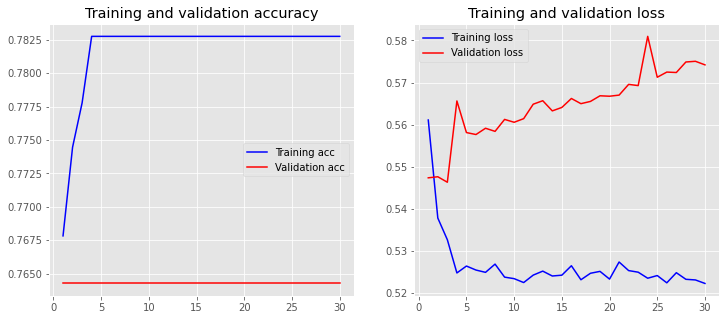

In [66]:
%time

history = model.fit(X_train_Tfidf, Y_train,
                    epochs = epochs,
                    verbose = False,
                    validation_data = (X_test_Tfidf, Y_test),
                    batch_size = batch_size)

loss, accuracy = model.evaluate(X_train_Tfidf, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_Tfidf, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## 4.2 Recurrent Neural Networks

https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

In [112]:
model = Sequential()
model.add(layers.Embedding(num_word, embedding_dim, input_length=X_train_keras.shape[1]))
model.add(layers.SpatialDropout1D(0.1))
model.add(layers.LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(output_label, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 50, 50)            250000    
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 50, 50)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 200)               200800    
_________________________________________________________________
dense_21 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 202       
Total params: 471,102
Trainable params: 471,102
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.7745
Testing Accuracy:  0.7643


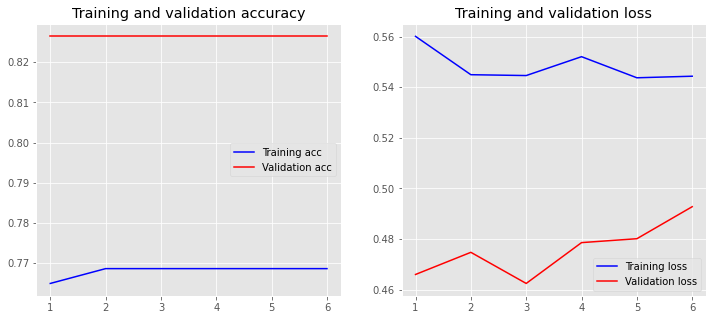

In [114]:
history = model.fit(X_train_keras, Y_train,
                    epochs = epochs,
                    verbose = False,
                    validation_data = (X_test_keras, Y_test),
                    batch_size = batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

loss, accuracy = model.evaluate(X_train_keras, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_keras, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## 4. Set up CNN Model 

In [44]:
del model

In [45]:
model = Sequential()

if use_pretrained_embeddings:  
  
    model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights = [embedding_matrix], 
                               input_length = seq_input_len, 
                               trainable = False))
else: 
    embedding_dim = 100 # Output Dimension - seq output length
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length = seq_input_len))

# Filters: No. of output filter in the convolution
# kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
model.add(layers.Conv1D(filters = 128, kernel_size = 2, activation='relu'))

# Global max pooling operation for 1D temporal data.
# Downsamples the input representation by taking the maximum value over the time dimension
#model.add(layers.GlobalMaxPooling1D())
model.add(layers.Conv1D(filters = 32, kernel_size = 3, activation='relu'))

model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(10, activation='relu'))

model.add(layers.Dense(output_label, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            150400    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 49, 128)           12928     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 47, 32)            12320     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
Total params: 176,033
Trainable params: 25,633
Non-trainable params: 150,400
___________________________________________

## 6. Run Model - CNN

In [57]:
type((X_test, Y_test))

tuple

Wall time: 0 ns
Training Accuracy: 0.9967
Testing Accuracy:  0.8486


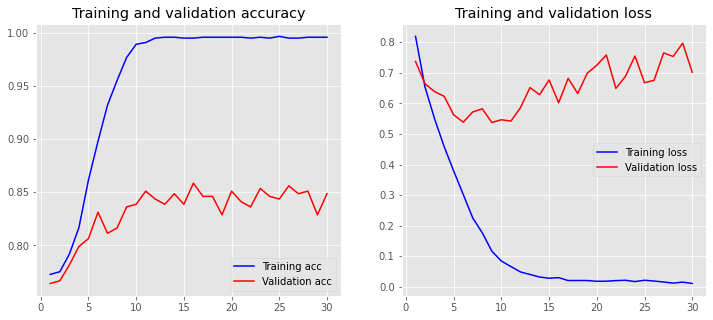

In [46]:
%time

history = model.fit(X_train, Y_train,
                    epochs = epochs,
                    verbose = False,
                    validation_data = (X_test, Y_test),
                    batch_size = batch_size)

loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [47]:
Y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)
cal_label_accuracy(conf_matrix, verbose = 1)

Accuracy for label 0 :  97.08  %
Accuracy for label 1 :  23.53  %
Accuracy for label 2 :  46.15  %
Accuracy for label 3 :  47.83  %
Accuracy for label 4 :  55.17  %


{0: 97.08, 1: 23.53, 2: 46.15, 3: 47.83, 4: 55.17}

In [50]:
Y_test.argmax(axis=1)

array([0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 0, 0, 1,
       0, 1, 0, 4, 3, 0, 0, 4, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 4, 2, 0, 0,
       3, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0,
       0, 4, 0, 3, 0, 4, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 3, 0,
       1, 2, 2, 0, 3, 0, 0, 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 3, 0, 0, 0, 3, 0, 0, 0, 1,
       0, 2, 2, 4, 0, 0, 0, 3, 0, 2, 4, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 4,
       0, 0, 0, 0, 0, 0, 4, 0, 2, 3, 0, 0, 0, 0, 0, 3, 4, 0, 4, 2, 0, 0,
       0, 3, 0, 0, 1, 0, 0, 4, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       1, 0, 0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 0, 0,

In [51]:
Y_pred.argmax(axis=1)

array([0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0,
       0, 4, 0, 3, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0,
       0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 2, 2, 4, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 3, 0, 0, 4,
       0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       2, 0, 0, 0, 0, 0, 2, 4, 3, 0, 0, 0, 0, 0, 0,

## 7. Run Model - Recurrent Neural Networks - RNN

Reference: https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

In [69]:
del model

In [70]:
model = Sequential()

if use_pretrained_embeddings:  
  
    model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights = [embedding_matrix], 
                               input_length = seq_input_len, 
                               trainable = False))
else: 
    embedding_dim = 100 # Output Dimension - seq output length
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length = seq_input_len))
    
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(10, activation='softmax'))
model.add(layers.Dense(output_label, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Training Accuracy: 0.5211
Testing Accuracy:  0.5022


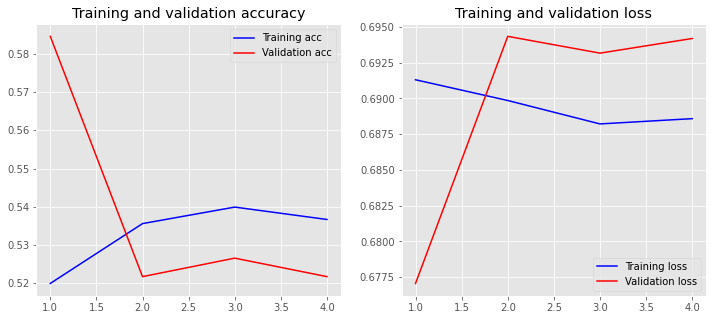

In [71]:
history = model.fit(X_train, 
                    Y_train, 
                    epochs = epochs, 
                    batch_size = batch_size,
                    validation_data = (X_test, Y_test), 
                    validation_split=0.1,
                    verbose = False,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [72]:
Y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)
cal_label_accuracy(conf_matrix, verbose = 1)

Accuracy for label 0 :  4.3  %
Accuracy for label 1 :  97.63  %


{0: 4.3, 1: 97.63}